# Drawing App
我們來實作一個可以辨識手寫數字的python程式吧！<br/><br/>
這個程式有三個部分要完成：
1. 讓使用者可以寫一個數字，並把數字轉成一個 array
1. 把這個 array 進行 preprocess ，變成一個可以直接丟進 model 的格式
1. 載入上次訓練好的 model 並且使用 `predict` 函數預測結果



# 讓使用者可以寫數字

這邊的程式碼比較複雜，不必深究，我自己也是從網路上看一些範例整合出來的 XD

我們先 import 跟繪圖有關的套件

In [1]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
import base64
import matplotlib.pyplot as plt

from PIL import Image
import io
import torch


這邊是跟機器學習有關的 import ，可以發現比訓練時要 import 的少很多，因為我們要直接用訓練好的 model

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


這段是設定寫數字的畫布(canvas)的樣子，是其他語法(JavaScript和HTML)寫成的，如果有興趣學習怎麼架網站的同學，這兩個語法非常重要，可以有空自行學習。

In [3]:


canvas_html = """
<div>
<canvas width=%d height=%d></canvas>
<button>Finish</button>
</div>
<script>
var div = document.querySelector('div')
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
div.style.display = 'flex'
div.style.flex_direction = 'row'
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
canvas.style.border = 'thick solid #0000FF'
var onPaint = () => {
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = () => {
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""


把寫好的數字圖片顯示出來的程式，跟我們上次用的一樣！只是這邊我們把它變成一個函式(function)，之後只要寫一行`plot(data)`就可以用了！

In [4]:
def plot(data):
  H = np.array(data)  # added some commas and array creation code

  fig = plt.figure(figsize=(6, 3.2))

  ax = fig.add_subplot(111)
  ax.set_title('colorMap')
  plt.imshow(H)
  ax.set_aspect('equal')

  cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
  cax.get_xaxis().set_visible(False)
  cax.get_yaxis().set_visible(False)
  cax.patch.set_alpha(0)
  cax.set_frame_on(False)
  plt.colorbar(orientation='vertical')
  plt.show()

設定圖片的寬度（記得我們之前訓練時是用28*28的圖片嗎？）

In [5]:
IMAGE_WIDTH = 28

以下這段程式碼會在 Google Colab 裡面創建一個寫字區域，然後把寫完的數字轉成 **IMAGE_WIDTH * IMAGE_WIDTH 的二維陣列**

In [6]:
def draw(filename='drawing.png', w=400, h=200, line_width=10):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  
  base64_decoded = base64.b64decode(data.split(',')[1])

  image = Image.open(io.BytesIO(base64_decoded)).resize((IMAGE_WIDTH,IMAGE_WIDTH))
  image_array = np.asarray(image)

  result = np.zeros((IMAGE_WIDTH,IMAGE_WIDTH))

  for i in range(IMAGE_WIDTH):
    for j in range(IMAGE_WIDTH):
      if  sum(image_array[i][j])*2 > 255 :

        result[i][j] =  255 
      else:
        result[i][j] = sum(image_array[i][j])*2
  plot(result)
  """
  with open(filename, 'wb') as f:
    f.write(base64_decoded)
  """
  
  return result

# 載入模型
我們先把之前下載的 `mnist_DNN.h5` 檔案上傳到資料夾裡面，步驟如下：

1. 點左側的資料夾圖示
2. 按右鍵，點選 `新增資料夾`
3. 資料夾取名為 `models` （其實可以取其他名字，但等一下載入 model 時的路徑要跟資料夾名稱一致）
4. 在 `models` 上面按右鍵，點選 `上傳` 
5. 找到之前下載的 `mnist_DNN.h5` 檔案並上傳

上傳完成之後就大功告成了！



接下來就跟之前 Keras_Basic 教過的方法一樣，用以下這兩行程式碼把 model 載入到程式裡面（如果你的資料夾不是取名`models`，記得要把下面`models`的地方改成你自己取的資料夾名稱喔）

In [8]:
from tensorflow.keras.models import load_model
model_CNN = load_model('models/mnist_CNN.h5')
model_DNN = load_model('models/mnist_DNN.h5')

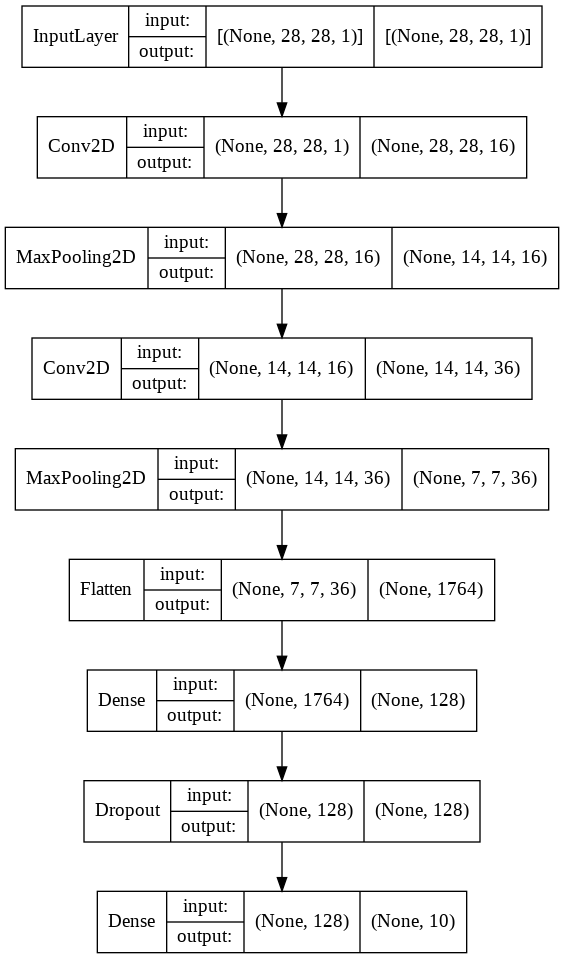

In [9]:
tf.keras.utils.plot_model(
   model_CNN,
   to_file = 'model_CNN.png',
   show_shapes = True,
   show_layer_names = False
) 

In [11]:
tf.keras.utils.plot_model(
   model_DNN,
   to_file = 'model_DNN.png',
   show_shapes = True,
   show_layer_names = False
) 

NameError: ignored

# 開始繪圖！
以上的程式碼並不需要深入了解，只要知道它會創建一個畫布讓我們寫數字，然後把數字圖片轉成一個二維陣列

以下這一行程式基本上做兩件事情：
1. 創建一個 224*224 像素的畫布
1. 把寫好的數字變成一個二維陣列，丟進 `data`

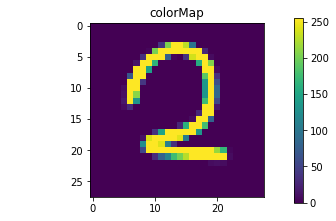

In [12]:
 X_TEST = draw(w=224,h=224)

# 資料預處理（Preprocess）

還記得上次 preprocess 的步驟嗎？
  * 把圖片的每一格的值除以 255，也就是每一個的值介於 0~1
  * 把 28*28 的二維陣列變成 784 的一維陣列： <br/>
    `X_train = X_train.reshape(60000, 784).astype('float32')  `

我們用 `plot()` 函式檢查一下是不是跟剛剛寫的數字長的一樣。

In [13]:
# CNN preprocess
x_test_CNN = np.array([X_TEST])
print(x_test_CNN.shape)
x_test_CNN = x_test_CNN / 255

x_test_CNN = np.expand_dims(x_test_CNN, axis=3)
print(x_test_CNN.shape)

(1, 28, 28)
(1, 28, 28, 1)


In [14]:
# DNN preprocess
x_test_DNN = np.array([X_TEST.reshape(784).astype('float32')])
print(x_test_DNN.shape)

(1, 784)


# 預測

接下來就可以直接用 model 進行預測啦！

In [16]:
predicted_CNN = model_CNN.predict(x_test_CNN, batch_size=10, verbose=1)
predicted_DNN = model_DNN.predict(x_test_DNN, batch_size=10, verbose=1)

1/1 [==============================] - 0s 31ms/step


我們把 `predicted` 換成機率的形式，因為我們最後一個 layer 是用softmax 當激勵函數，所以我們用 `tf.nn.softmax()` 函式轉回機率的值。（這個轉換不會影響結果，只是可以標準化不同選項的可能性）

In [17]:
predicted_CNN = tf.nn.softmax(predicted_CNN).numpy()
predicted_DNN = tf.nn.softmax(predicted_DNN).numpy()

`predict`這個函式會回傳一個陣列，告訴我們模型覺得輸入圖片是 0~9 中某個數字的機率是多少，因此機率最大的就是模型覺得這個圖片最像哪個數字。<br/>
下面這一段程式只是把 `predicted` 排序，然後由機率高到低 print 出來

In [18]:
# CNN
rank_CNN = sorted(range(len(predicted_CNN[0])), key=lambda k: predicted_CNN[0][k], reverse=True)
for i in range(len(predicted_CNN[0])):
  print( '數字: ', rank_CNN[i] , '  機率: ' , predicted_CNN[0][rank_CNN[i]]*100 , '%')

數字:  2   機率:  23.19691628217697 %
數字:  7   機率:  8.533681184053421 %
數字:  8   機率:  8.533675968647003 %
數字:  0   機率:  8.533675223588943 %
數字:  1   機率:  8.533675223588943 %
數字:  3   機率:  8.533675223588943 %
數字:  4   機率:  8.533675223588943 %
數字:  5   機率:  8.533675223588943 %
數字:  6   機率:  8.533675223588943 %
數字:  9   機率:  8.533675223588943 %


In [ ]:
# DNN
rank_DNN = sorted(range(len(predicted_DNN[0])), key=lambda k: predicted_DNN[0][k], reverse=True)
for i in range(len(predicted_DNN[0])):
  print( '數字: ', rank_DNN[i] , '  機率: ' , predicted_DNN[0][rank_DNN[i]]*100 , '%')

我們也可以直接把答案print出來！

# 答案！

In [ ]:
print('CNN 預測：', rank_CNN[0])
print('DNN 預測：', rank_DNN[0])